# NBA 2018-2019 Season Analysis (Work in Progress)

For this project, we will analyze the NBA 2018-2019 season based on players' per-game and advanced stats.  In particular, we will perform clustering on players' offensive and defensive stats separately.

The data was obtained from Basketball Reference (click [here](https://www.basketball-reference.com/leagues/NBA_2019_per_game.html) for per-game stats and [here](https://www.basketball-reference.com/leagues/NBA_2019_advanced.html) for advanced stats).  For column definitions, click on "Glossary" in the two aforementioned links.

In [203]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.decomposition import PCA

plt.style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None

## 1. Data Processing

The first step in our data analysis is to clean the data.  We have two datasets at our disposal, e.g. the per-game stats and advanced stats.  Let's first preview the datasets by displaying their first five rows.

In [236]:
# Read the data
per_game = pd.read_csv('NBA2018-19PerGameStats.txt')  # Per-game stats
advanced = pd.read_csv('NBA2018-19AdvancedStats.txt')  # Advanced stats

# Remove missing columns
advanced.drop(advanced.columns[[19, 24]], axis=1, inplace=True)

# Preview the data
display(per_game.head())
advanced.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,588,6.3,0.507,0.809,...,7.9,12.2,0.1,0.6,0.6,0.053,-3.7,0.4,-3.3,-0.2
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,123,2.9,0.379,0.833,...,15.2,9.2,-0.1,0.0,-0.1,-0.022,-7.6,-0.5,-8.1,-0.2
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,428,7.6,0.474,0.673,...,19.7,13.5,-0.1,0.2,0.1,0.011,-3.8,-0.5,-4.3,-0.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,2669,18.5,0.591,0.002,...,12.6,16.4,5.1,4.0,9.1,0.163,0.7,0.4,1.1,2.1
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,1913,17.9,0.623,0.031,...,17.1,15.8,3.4,3.4,6.8,0.171,-0.4,2.2,1.8,1.8


Inspection of the datasets shows that some players have multiple rows of data; these are players that played for more than one team.  The first row for these players is their aggregated stats, which we want to keep; we can drop the other rows that correspond to stats for each team they played for.

After dropping the redundant columns such as 'Rk' and 'Pos' from the advanced stats, we can merge the two datasets.

In [237]:
# Keep only totals for players with multiple rows (players that played for more than one team)
per_game.drop_duplicates(subset=['Rk'], inplace=True)
advanced.drop_duplicates(subset=['Rk'], inplace=True)

# Drop redundant columns from advanced
advanced.drop(['Rk', 'Pos', 'Age', 'Tm', 'G', 'MP'], axis=1, inplace=True)

# Merge per_game and advanced
data = pd.merge(per_game, advanced, how='left', on='Player')

# Remove the 8 players listed with multiple positions
data = data[data.Pos.isin(['PG', 'SG', 'SF', 'PF', 'C'])]

# Clean the Player column
data['Player'] = data['Player'].map(lambda x: x.split('\\')[0])

# Set the Player column as index
data.set_index('Player', inplace=True)

# Preview the merged data
data.head()

,Rk,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
Player,,,,,,,,,,,,,,,,,,,,,
Álex Abrines,1,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,...,7.9,12.2,0.1,0.6,0.6,0.053,-3.7,0.4,-3.3,-0.2
Quincy Acy,2,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,...,15.2,9.2,-0.1,0.0,-0.1,-0.022,-7.6,-0.5,-8.1,-0.2
Jaylen Adams,3,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,...,19.7,13.5,-0.1,0.2,0.1,0.011,-3.8,-0.5,-4.3,-0.2
Steven Adams,4,C,25,OKC,80,80,33.4,6.0,10.1,0.595,...,12.6,16.4,5.1,4.0,9.1,0.163,0.7,0.4,1.1,2.1
Bam Adebayo,5,C,21,MIA,82,28,23.3,3.4,5.9,0.576,...,17.1,15.8,3.4,3.4,6.8,0.171,-0.4,2.2,1.8,1.8


For our analysis, we want to remove players players that played less than half the season (41 games) and less than 20 minutes per game.  There are many of these players that played low minutes, which can skew our analysis.  We do this because we want to focus our analysis on the players that played significant minutes and thus are vital contributors to their teams.  In addition, we replace missing values with 0 since they correspond to undefined percentages; for example, a player who has not attempted a 3-point field goal will have a missing value in the '3P%' column.

After performing all these data processing tasks, we are left with 225 players or rows and 49 columns.

In [238]:
# Remove players that played less than half the season and less than 20 minutes per game
data = data[(data.G >= 41) & (data.MP >= 20)]

# Replace missing values with 0
data.fillna(0, inplace=True)

# Final data dimensions
data.shape

(225, 49)

## 2. Exploratory Data Analysis

We begin our exploratory data analysis by looking at the summary statisics of the data.  We see, for example, that the average age is 26, the average points per game is 13.4, and the average TS% (True shooting percentage, which is a measure of shooting efficiency) is 56.1%. 

In [239]:
# Summary statistics (per-game stats)
data.drop('Rk', axis=1).iloc[:, :28].describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,26.155556,69.564444,47.164444,27.683111,4.958222,10.683556,0.463689,1.355556,3.774222,0.330822,...,0.767440,1.155111,4.048000,5.200889,3.007111,0.896000,0.564000,1.627556,2.266667,13.427556
std,3.892275,11.157820,26.259770,4.486555,1.995584,4.086404,0.060480,0.859961,2.216064,0.088227,...,0.090053,0.931964,1.889139,2.641682,1.968285,0.362693,0.478551,0.802866,0.560054,5.649490
min,19.000000,42.000000,0.000000,20.000000,1.500000,4.000000,0.337000,0.000000,0.000000,0.000000,...,0.417000,0.200000,1.400000,1.700000,0.500000,0.100000,0.000000,0.300000,1.100000,4.300000
25%,23.000000,64.000000,24.000000,23.900000,3.400000,7.400000,0.422000,0.800000,2.500000,0.323000,...,0.716000,0.500000,2.700000,3.300000,1.500000,0.600000,0.300000,1.000000,1.900000,9.300000
50%,26.000000,73.000000,52.000000,27.500000,4.400000,9.700000,0.448000,1.300000,3.700000,0.348000,...,0.783000,0.800000,3.600000,4.500000,2.400000,0.800000,0.400000,1.500000,2.200000,11.900000
75%,29.000000,79.000000,72.000000,31.400000,6.000000,13.000000,0.487000,1.900000,5.000000,0.372000,...,0.836000,1.400000,5.000000,6.500000,3.900000,1.100000,0.700000,2.000000,2.600000,16.600000
max,37.000000,82.000000,82.000000,36.900000,10.800000,24.500000,0.694000,5.100000,13.200000,0.529000,...,0.928000,5.400000,11.100000,15.600000,10.700000,2.200000,2.700000,5.000000,3.800000,36.100000


In [240]:
# Summary statistics (advanced stats)
data.drop('Rk', axis=1).iloc[:, 28:].describe()

,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,15.496444,0.561449,0.364249,0.251338,4.499556,15.571111,10.033778,15.761333,1.535556,1.751111,11.947556,20.319556,2.384889,2.006222,4.389333,0.104316,0.321778,0.058667,0.379556,1.311556
std,4.829623,0.044260,0.187072,0.108984,3.533166,6.369845,4.663289,9.129684,0.513894,1.516490,3.195715,5.529537,2.203071,1.101118,2.936527,0.057580,2.405206,1.186655,2.813683,1.666677
min,6.000000,0.417000,0.000000,0.068000,0.700000,6.000000,3.800000,4.100000,0.300000,0.000000,3.700000,9.500000,-2.800000,-0.500000,-1.700000,-0.045000,-5.200000,-3.300000,-6.000000,-2.000000
25%,12.000000,0.534000,0.255000,0.169000,2.100000,10.900000,6.600000,8.800000,1.100000,0.900000,9.700000,16.400000,0.900000,1.200000,2.300000,0.062000,-1.300000,-0.700000,-1.600000,0.200000
50%,14.400000,0.561000,0.367000,0.231000,3.100000,14.100000,8.700000,12.500000,1.500000,1.300000,11.500000,19.300000,2.000000,1.800000,3.700000,0.100000,-0.100000,0.100000,0.000000,1.000000
75%,18.500000,0.588000,0.500000,0.312000,5.400000,18.900000,12.400000,21.200000,1.900000,2.200000,13.800000,23.800000,3.700000,2.800000,6.100000,0.134000,1.400000,0.800000,1.600000,1.900000
max,30.900000,0.692000,0.814000,0.733000,16.800000,35.600000,25.900000,46.500000,3.100000,10.000000,26.800000,40.500000,11.400000,5.900000,15.200000,0.292000,9.400000,4.100000,11.000000,9.300000


Interestingly, the number of players for each position (PG, SG, SF, PF, C) is not quite uniform: there is a prevalence of point guards (PG) and shooting guards (PG).

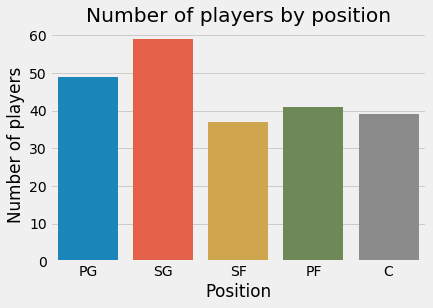

In [278]:
# Reorder positions
data.Pos = data.Pos.astype('category')
data.Pos.cat.reorder_categories(['PG', 'SG', 'SF', 'PF', 'C'], inplace=True)

# Number of players by position
sns.countplot(x='Pos', data=data)
plt.xlabel('Position')
plt.ylabel('Number of players')
plt.title('Number of players by position');

If we group the players by position, we can get an idea for the roles and contributions of each position.  It's no surprise that point guards average the most AST (assists per game) and centers average the most TRB (total rebounds per game).

In [301]:
# Counting stats by position
data.groupby('Pos')[['PTS', 'TRB', 'AST', 'TOV', 'STL', 'BLK']].mean().round(2)

,PTS,TRB,AST,TOV,STL,BLK
Pos,,,,,,
PG,13.95,3.82,5.22,2.04,1.07,0.31
SG,13.42,3.47,2.63,1.47,0.85,0.32
SF,12.62,4.78,2.41,1.43,0.96,0.47
PF,12.90,6.20,2.19,1.51,0.77,0.62
C,14.12,8.91,2.23,1.65,0.81,1.28


In [302]:
# Efficiency measures by position
data.groupby('Pos')[['FG%', 'FGA', '3P%', '3PA', 'FT%', 'FTA', 'TS%']].mean().round(2)

,FG%,FGA,3P%,3PA,FT%,FTA,TS%
Pos,,,,,,,
PG,0.44,11.48,0.34,4.24,0.79,2.89,0.54
SG,0.43,11.15,0.36,4.94,0.79,2.36,0.55
SF,0.45,10.12,0.34,3.93,0.75,2.63,0.55
PF,0.47,10.03,0.35,3.70,0.77,2.75,0.57
C,0.56,10.19,0.23,1.36,0.72,3.52,0.61


The plot of points per game by true shooting percentage shows James Harden of the Houston Rockets as an outlier: his league leading 36.1 points per game is well above the 28 points per game of the second leading scorer, Paul George.  Another outlier is Frank Ntilikina of the New York Knicks who scored 5.7 points per game on 41.7 TS%.  In the bottom right of the graph, we see that there are a few centers who scores very efficiently but not much in terms of volume.

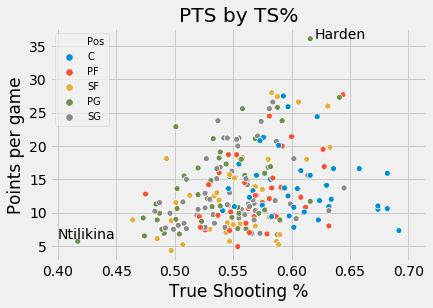

In [279]:
plt.rc('legend', fontsize=10)

# Scatter plot of PPG by TS%
g = sns.scatterplot(x='TS%', y='PTS', data=data, hue='Pos')
plt.xlabel('True Shooting %')
plt.ylabel('Points per game')
plt.title('PTS by TS%')
plt.legend(loc='upper left')
plt.annotate(s='Harden', xy=(0.62, 36.1))
plt.annotate(s='Ntilikina', xy=(0.4, 6));

The plot of turnovers per game by assists per game shows Harden and Westbrook as outliers.  Harden leads the league in turnovers per game, and Westbrook leads the league in assists per game and is also second in turnovers per game. 

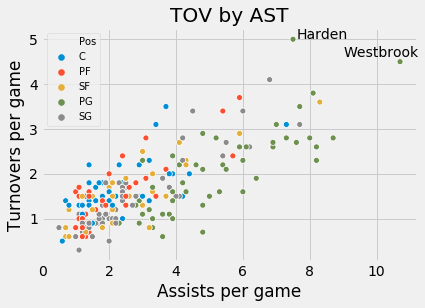

In [280]:
# Scatter plot of TOV by AST
g = sns.scatterplot(x='AST', y='TOV', data=data, hue='Pos')
plt.xlabel('Assists per game')
plt.ylabel('Turnovers per game')
plt.title('TOV by AST')
plt.annotate(s='Harden', xy=(7.6, 5))
plt.annotate(s='Westbrook', xy=(9, 4.6));

## 3. *k*-means Clustering

In [ ]:
# List of offensive stats
offense_features = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'AST', 'TOV', 
                    'PTS', 'TS%', '3PAr', 'FTr', 'ORB%', 'AST%', 'TOV%', 'USG%', 'OWS', 'OBPM']
# List of defensive stats
defense_features = ['DRB', 'STL', 'BLK', 'DRB%', 'STL%', 'BLK%', 'DWS', 'DBPM']

# Dataframe of offensive stats
data_offense = data[offense_features]
# Dataframe of defensive stats
data_defense = data[defense_features]

### 3a. Clustering on Offensive Stats

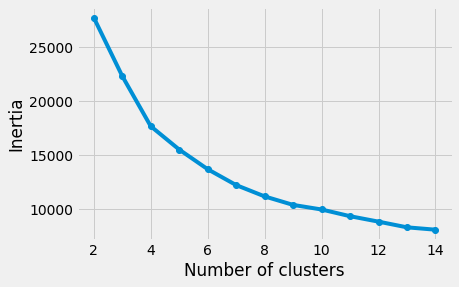

In [282]:
ks = range(2, 15)
inertias = []

# Calculate inertia for 2 to 15 clusters
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(data_offense)
    inertias.append(model.inertia_)
    
# Plot of inertia vs. number of clusters
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

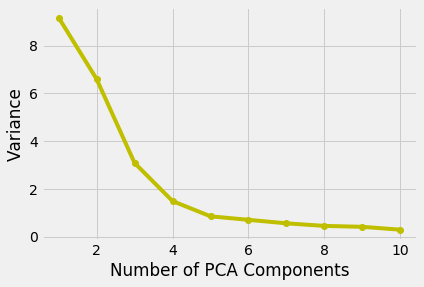

In [284]:
# Scale the features to have mean 0 and variance 1
scaler = StandardScaler()
# Apply PCA
pca = PCA()
# Choose 4 as the number of clusters
kmeans = KMeans(n_clusters=4)
# Create pipeline
pipeline = make_pipeline(scaler, pca, kmeans)
# Fit pipeline to data
pipeline.fit(data_offense)
# Calculate the cluster labels
data_offense['cluster'] = pipeline.predict(data_offense)

# Plot of explained variance vs. number of PCA components
n_components = range(1, 11)
plt.plot(n_components, pca.explained_variance_[:10], '-o', c='y')
plt.xlabel('Number of PCA Components')
plt.ylabel('Variance');

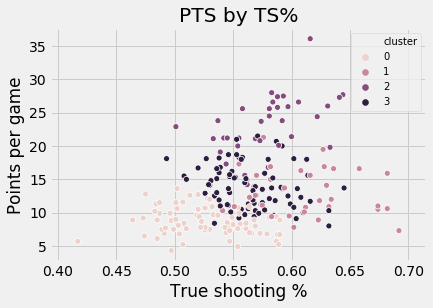

In [285]:
# Scatter plot of PPG by TS%
g = sns.scatterplot(x='TS%', y='PTS', data=data_offense, hue='cluster')
plt.xlabel('True shooting %')
plt.ylabel('Points per game')
plt.title('PTS by TS%');

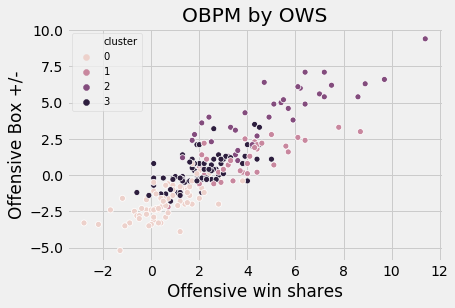

In [286]:
# Scatter plot of PPG by TS%
g = sns.scatterplot(x='OWS', y='OBPM', data=data_offense, hue='cluster')
plt.xlabel('Offensive win shares')
plt.ylabel('Offensive Box +/-')
plt.title('OBPM by OWS');

In [306]:
data_offense.groupby('cluster')[['PTS', 'ORB', 'AST', 'TOV', 'USG%', 'OWS', 'OBPM']].mean().round(2)

,PTS,ORB,AST,TOV,USG%,OWS,OBPM
cluster,,,,,,,
0,8.63,0.74,2.69,1.28,16.30,0.64,-1.82
1,13.12,2.77,1.98,1.56,19.83,3.95,1.08
2,23.24,1.23,5.89,2.95,29.19,5.14,4.33
3,13.89,0.79,2.54,1.42,20.54,2.15,0.28


In [304]:
data_offense.groupby('cluster')[['FG%', 'FGA', '3P%', '3PA', 'FT%', 'FTA', 'TS%']].mean().round(2)

,FG%,FGA,3P%,3PA,FT%,FTA,TS%
cluster,,,,,,,
0,0.43,7.59,0.34,3.17,0.73,1.51,0.53
1,0.57,9.38,0.21,0.78,0.69,3.37,0.61
2,0.47,17.41,0.35,5.86,0.81,5.95,0.58
3,0.45,11.32,0.37,4.80,0.82,2.39,0.56


In [ ]:
data_offense.groupby('cluster').

### 3b. Clustering on Defensive Stats

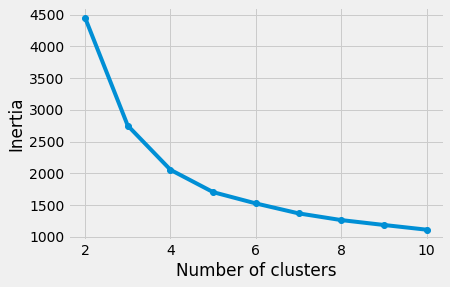

In [293]:
ks = range(2, 11)
inertias = []

# Calculate inertia for 2 to 10 clusters
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(data_defense)
    inertias.append(model.inertia_)
    
# Plot of inertia vs. number of clusters
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show();

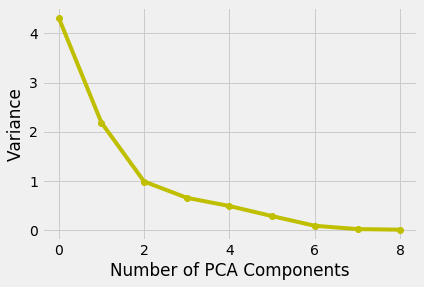

In [288]:
# Scale the features to have mean 0 and variance 1
scaler = StandardScaler()
# Apply PCA
pca = PCA()
# Choose 4 as the number of clusters
kmeans = KMeans(n_clusters=4)
# Create pipeline
pipeline = make_pipeline(scaler, pca, kmeans)
# Fit pipeline to data
pipeline.fit(data_defense)
# Calculate the cluster labels
data_defense['cluster'] = pipeline.predict(data_defense)

# Plot of explained variance vs. number of PCA components
n_components = range(pca.n_components_)
plt.plot(n_components, pca.explained_variance_, '-o', c='y')
plt.xlabel('Number of PCA Components')
plt.ylabel('Variance');

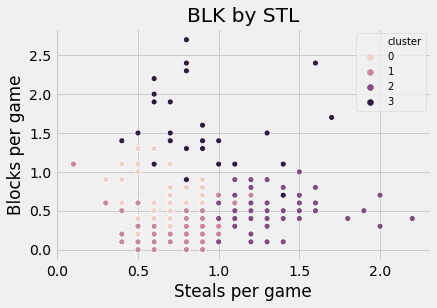

In [291]:
# Scatter plot of BLK by STL
g = sns.scatterplot(x='STL', y='BLK', data=data_defense, hue='cluster')
plt.xlabel('Steals per game')
plt.ylabel('Blocks per game')
plt.title('BLK by STL');

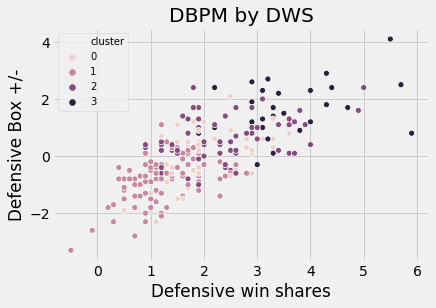

In [290]:
# Scatter plot of DBPM by DWS
g = sns.scatterplot(x='DWS', y='DBPM', data=data_defense, hue='cluster')
plt.xlabel('Defensive win shares')
plt.ylabel('Defensive Box +/-')
plt.title('DBPM by DWS');